# Classification IMDb using GRU
## Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
num_words = 50000  # 50,000 words
maxlen = 300  # Maximum sequence length

In [ ]:

# Load dataset IMDb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Padding sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


In [ ]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Create DataLoader for training and testing data
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
hidden_size = 64  # Reduced hidden size


In [ ]:
device = torch.device("cpu")  # Use CPU for evaluation
model = model.to(device)


In [ ]:
inputs, labels = inputs.to(device), labels.to(device)


In [ ]:
import torch
torch.cuda.empty_cache()  # Clear unused memory in the GPU


In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast

# Ensure the device is set to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
model = model.to(device)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Training loop with mixed precision
for inputs, labels in train_loader:
    # Move inputs and labels to the correct device
    inputs, labels = inputs.to(device), labels.to(device)

    # Set the model to training mode
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Enable autocast for mixed precision
    with autocast():  # autocast automatically uses the correct device (cuda if available)
        outputs = model(inputs)  # Model outputs logits (no need for sigmoid)
        loss = criterion(outputs.squeeze(), labels)  # Loss function expects logits, not probabilities

    # Scales the loss and calls backward()
    scaler.scale(loss).backward()

    # Optimizer step with scaling
    scaler.step(optimizer)

    # Update the scaler
    scaler.update()


<ipython-input-36-aade9ddec17a>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-36-aade9ddec17a>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # autocast automatically uses the correct device (cuda if available)


In [ ]:
from torch.utils.checkpoint import checkpoint

class GRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUNetwork, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=128)
        self.gru = nn.GRU(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        # Apply checkpointing
        out, _ = checkpoint(self.gru, x)
        out = out[:, -1, :]  # Take last hidden state
        out = self.fc(out)
        return self.sigmoid(out)


In [ ]:
# Hyperparameters for the model
hidden_size = 128
num_layers = 2
output_size = 1

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUNetwork(input_size=128, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Define the training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        val_loss, val_accuracy = evaluate(model, test_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [ ]:
# Define the evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
# Train the model
history = train(model, train_loader, criterion, optimizer, epochs=5)

Epoch 1/5, Loss: 0.5017, Accuracy: 0.7398, Val Loss: 0.3559, Val Accuracy: 0.8401
Epoch 2/5, Loss: 0.2456, Accuracy: 0.8983, Val Loss: 0.2703, Val Accuracy: 0.8864
Epoch 3/5, Loss: 0.1400, Accuracy: 0.9483, Val Loss: 0.3170, Val Accuracy: 0.8713
Epoch 4/5, Loss: 0.0680, Accuracy: 0.9766, Val Loss: 0.3794, Val Accuracy: 0.8759
Epoch 5/5, Loss: 0.0337, Accuracy: 0.9890, Val Loss: 0.4734, Val Accuracy: 0.8658


In [ ]:
maxlen = 200  # Reduced input sequence length


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Evaluation Results:
Loss: 0.4734
Accuracy: 0.8658
Precision: 0.8368
Recall: 0.9089
F1 Score: 0.8713
F1 Squared: 0.7592
AUC: 0.8658


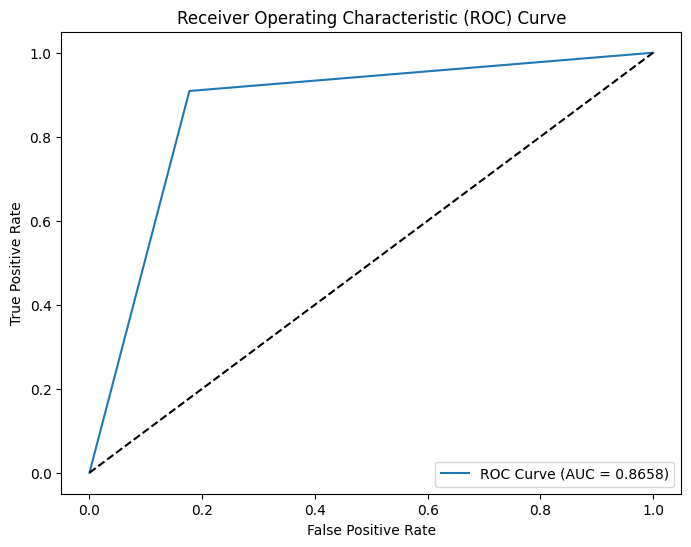

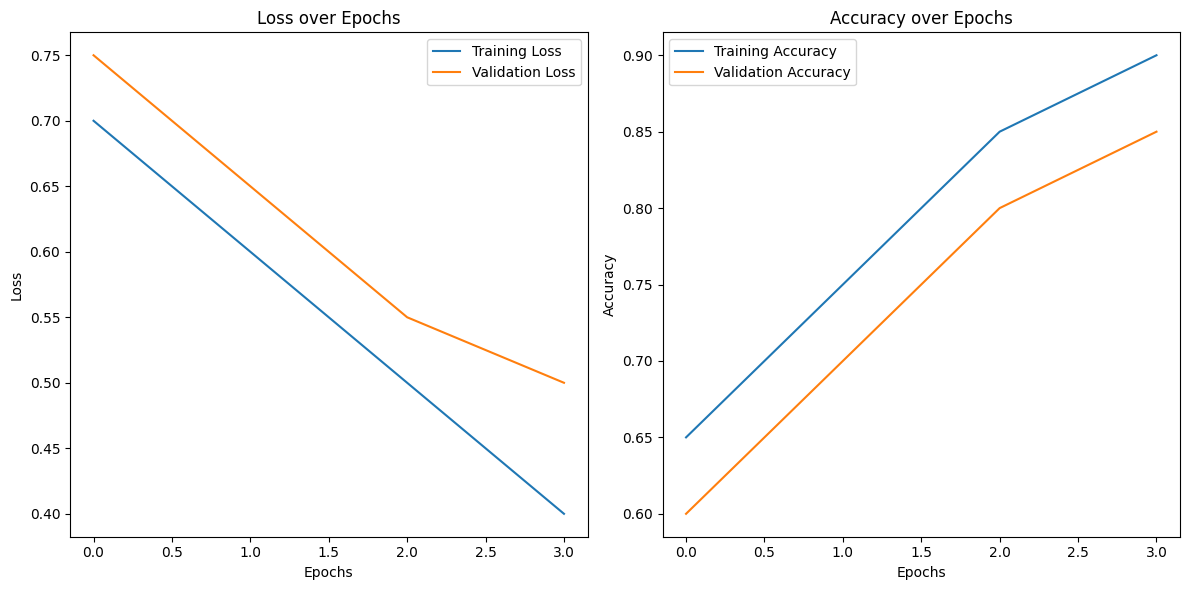

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the evaluation function
def evaluate(model, test_loader, criterion, device, history=None):
    # Set the model to evaluation mode
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation to save memory
        for inputs, labels in test_loader:
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item()

            # Get predictions
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for later metric calculations
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total

    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    f1_squared = f1 ** 2  # F1 Squared
    auc = roc_auc_score(all_labels, all_preds)

    # Print the evaluation metrics
    print(f"Evaluation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1 Squared: {f1_squared:.4f}")
    print(f"AUC: {auc:.4f}")

    # Compute ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

    # Plot the ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (chance level)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Visualize accuracy and loss over epochs
    if history:
        # Loss plot
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return avg_loss, accuracy, precision, recall, f1, f1_squared, auc

history = {
    'loss': [0.7, 0.6, 0.5, 0.4],  # Example loss over epochs
    'val_loss': [0.75, 0.65, 0.55, 0.5],  # Example validation loss over epochs
    'accuracy': [0.65, 0.75, 0.85, 0.9],  # Example accuracy over epochs
    'val_accuracy': [0.6, 0.7, 0.8, 0.85]  # Example validation accuracy over epochs
}

# Evaluate the model on test data
loss, accuracy, precision, recall, f1, f1_squared, auc = evaluate(model, test_loader, criterion, device, history)


# **Tensorflow**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Build the GRU model in TensorFlow
model = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
    GRU(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', AUC()])


In [ ]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6726 - auc: 0.7447 - loss: 0.5781 - val_accuracy: 0.8640 - val_auc: 0.9356 - val_loss: 0.3269
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9140 - auc: 0.9710 - loss: 0.2180 - val_accuracy: 0.8757 - val_auc: 0.9465 - val_loss: 0.3110
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9675 - auc: 0.9938 - loss: 0.0933 - val_accuracy: 0.8654 - val_auc: 0.9430 - val_loss: 0.3657
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9886 - auc: 0.9989 - loss: 0.0365 - val_accuracy: 0.8613 - val_auc: 0.9310 - val_loss: 0.4833
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9944 - auc: 0.9996 - loss: 0.0181 - val_accuracy: 0.8623 - val_auc: 0.9238 - val_loss: 0.5815


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8599 - auc: 0.9222 - loss: 0.5986
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
Evaluation Results:
Loss: 0.5815
Accuracy: 0.8623
Precision: 0.8394
Recall: 0.8960
F1 Score: 0.8668
F1 Squared: 0.7513
AUC: 0.8623


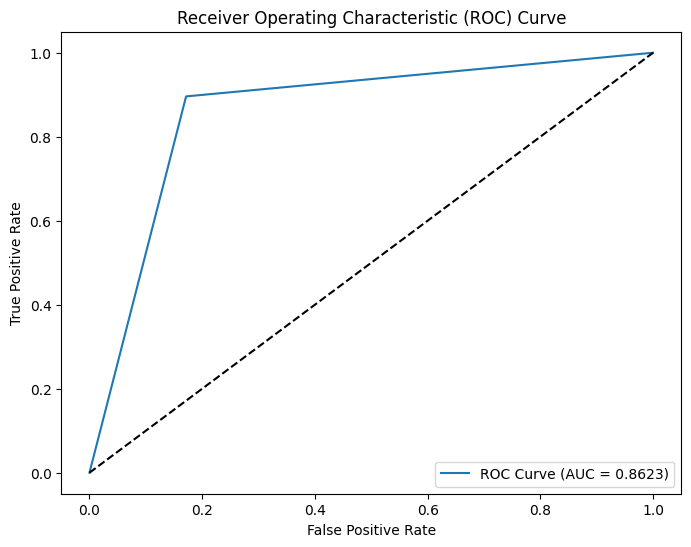

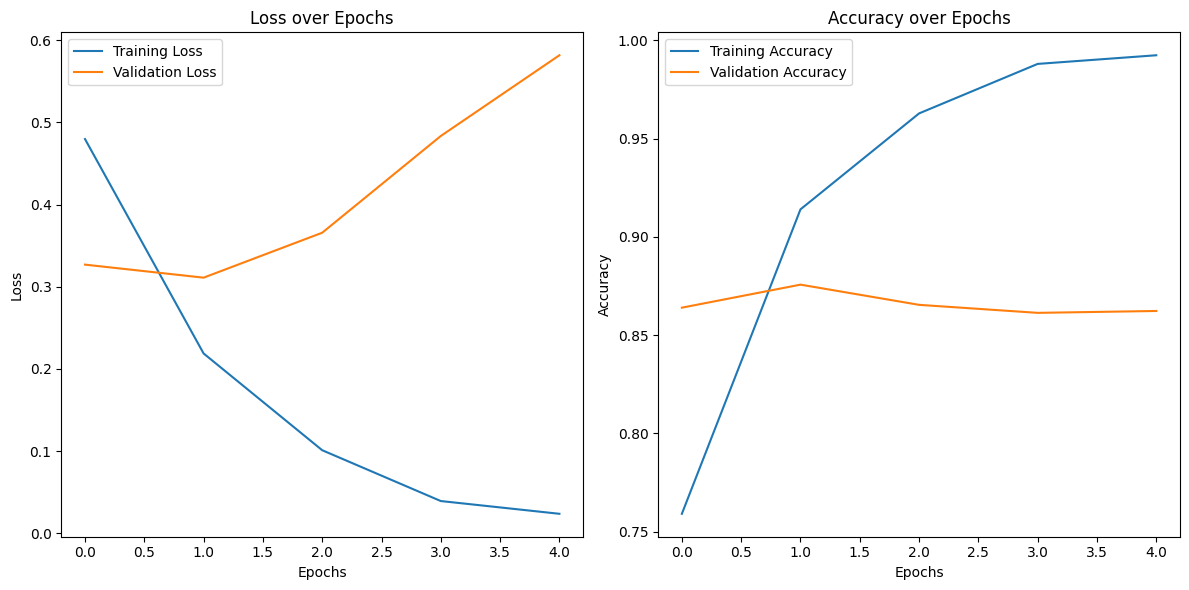

In [ ]:
# Define the evaluation function
def evaluate(model, x_test, y_test):
    # Evaluate the model on test data
    loss, accuracy, auc = model.evaluate(x_test, y_test)

    # Get predictions
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5)

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_squared = f1 ** 2  # F1 Squared
    auc_score = roc_auc_score(y_test, y_pred)

    # Print the evaluation metrics
    print(f"Evaluation Results:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1 Squared: {f1_squared:.4f}")
    print(f"AUC: {auc_score:.4f}")

    # Compute ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot the ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (chance level)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Visualize accuracy and loss over epochs
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return loss, accuracy, precision, recall, f1, f1_squared, auc_score

# Evaluate the model on test data
loss, accuracy, precision, recall, f1, f1_squared, auc = evaluate(model, x_test, y_test)

# Penjelasan Metrik Evaluasi Model Klasifikasi

## 1. **Akurasi (Accuracy)**
Akurasi mengukur seberapa sering model membuat prediksi yang benar dibandingkan dengan total prediksi yang dibuat.

**Persamaan**:
$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$

Dimana:
- **TP (True Positives)**: Jumlah prediksi yang benar untuk kelas positif.
- **TN (True Negatives)**: Jumlah prediksi yang benar untuk kelas negatif.
- **FP (False Positives)**: Jumlah prediksi yang salah untuk kelas positif.
- **FN (False Negatives)**: Jumlah prediksi yang salah untuk kelas negatif.

Akurasi menghitung rasio prediksi yang benar terhadap total prediksi yang dibuat oleh model.

## 2. **Presisi (Precision)**
Presisi mengukur seberapa tepat model dalam mengklasifikasikan kelas positif. Ini dihitung sebagai rasio antara prediksi positif yang benar dan semua prediksi yang diklasifikasikan sebagai positif oleh model.

**Persamaan**:
$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

Dimana:
- **TP**: True Positives (jumlah prediksi positif yang benar).
- **FP**: False Positives (jumlah prediksi positif yang salah).

Presisi mengukur **kebenaran** dari prediksi positif yang dibuat oleh model.

## 3. **Recall (Sensitivity atau True Positive Rate)**
Recall mengukur seberapa baik model dalam mendeteksi kelas positif yang sebenarnya. Ini dihitung sebagai rasio antara prediksi positif yang benar dengan jumlah keseluruhan instance yang benar-benar positif.

**Persamaan**:
$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

Dimana:
- **TP**: True Positives (jumlah prediksi positif yang benar).
- **FN**: False Negatives (jumlah prediksi negatif yang salah, tetapi seharusnya positif).

Recall mengukur **kemampuan model untuk menangkap semua kasus positif**.

## 4. **F1 Score**
F1 Score adalah rata-rata harmonis antara **presisi** dan **recall**. F1 score memberikan gambaran yang lebih baik mengenai keseimbangan antara presisi dan recall, terutama ketika data tidak seimbang (misalnya, jumlah positif jauh lebih sedikit daripada negatif).

**Persamaan**:
$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

F1 Score adalah pengukuran yang lebih baik daripada hanya menggunakan akurasi ketika data tidak seimbang.

## 5. **F1 Squared**
F1 Squared adalah kuadrat dari F1 Score. Ini memberikan bobot yang lebih besar pada nilai F1 dan mempertegas perbedaan antara model dengan nilai F1 yang hampir sama.

**Persamaan**:
$$
\text{F1 Squared} = (\text{F1 Score})^2
$$

F1 Squared lebih sensitif terhadap perubahan kecil dalam F1 score dan memberikan nilai antara 0 dan 1.

## 6. **AUC (Area Under the Curve)**
AUC (Area Under the ROC Curve) mengukur seberapa baik model dalam membedakan antara kelas positif dan negatif. Nilai AUC berkisar antara 0 dan 1, dimana 1 menunjukkan bahwa model sempurna, dan 0.5 menunjukkan model yang tidak lebih baik dari tebak-tebakan acak.

**Persamaan**:
$$
\text{AUC} = \int_0^1 \text{TPR}(t) \, \text{d}FPR(t)
$$

Dimana:
- **TPR (True Positive Rate)**: Seperti Recall, yaitu rasio instance positif yang terklasifikasikan dengan benar.
- **FPR (False Positive Rate)**: Rasio instance negatif yang salah terklasifikasikan sebagai positif.
- **t**: Titik threshold (nilai ambang batas).

AUC mengukur area di bawah kurva ROC dan memberi tahu kita bagaimana model berperforma secara keseluruhan pada berbagai nilai threshold.

## 7. **ROC Curve (Receiver Operating Characteristic Curve)**
ROC curve menggambarkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)** pada berbagai nilai threshold. ROC curve memberi gambaran bagaimana model berubah ketika kita mengubah ambang batas (threshold) dari prediksi.

**Persamaan**:
$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

Dimana:
- **TPR** adalah True Positive Rate (Recall).
- **FPR** adalah False Positive Rate (rasio instance negatif yang terklasifikasikan sebagai positif).

ROC Curve digunakan untuk **menilai kinerja model di berbagai titik threshold** dan menunjukkan trade-off antara TPR dan FPR.

## 8. **Confusion Matrix**
Confusion matrix adalah alat untuk menganalisis hasil klasifikasi model. Ini memberikan informasi tentang **True Positives (TP)**, **False Positives (FP)**, **True Negatives (TN)**, dan **False Negatives (FN)**.

**Format Confusion Matrix**:

$$
\begin{array}{|c|c|c|}
\hline
 & \text{Predicted Positive} & \text{Predicted Negative} \\
\hline
\text{Actual Positive} & \text{TP} & \text{FN} \\
\text{Actual Negative} & \text{FP} & \text{TN} \\
\hline
\end{array}
$$

- **TP**: Jumlah prediksi positif yang benar.
- **FP**: Jumlah prediksi positif yang salah.
- **TN**: Jumlah prediksi negatif yang benar.
- **FN**: Jumlah prediksi negatif yang salah.

Confusion matrix membantu kita untuk melihat **berapa banyak kesalahan** yang dibuat oleh model dalam klasifikasi.

## 9. **Precision-Recall Trade-off**
- **Precision** dan **Recall** sering kali memiliki **trade-off**: jika kita meningkatkan precision, recall cenderung menurun, dan sebaliknya. F1 Score menggabungkan kedua metrik ini untuk memberikan gambaran yang lebih seimbang.

---

## Visualisasi:
- **ROC Curve** memberikan gambaran bagaimana model bekerja pada berbagai threshold. Semakin dekat ROC curve ke sudut kiri atas, semakin baik kinerja model.
- **Confusion Matrix** memberikan gambaran lebih jelas tentang bagaimana model mengklasifikasikan berbagai contoh ke dalam kelas yang benar dan salah.
  
---

## Kesimpulan:
Setiap metrik di atas memberikan pandangan berbeda tentang seberapa baik model bekerja:
- **Akurasi** adalah metrik umum, tetapi bisa menyesatkan jika data tidak seimbang.
- **Precision** dan **Recall** berguna saat kelas positif atau negatif lebih penting.
- **F1 Score** memberikan keseimbangan antara precision dan recall.
- **AUC** dan **ROC Curve** memberikan gambaran tentang kemampuan model dalam membedakan antara kelas.
